# **NLP_&_INSURANCE: TEXT_CLASSIFICATION**

![](https://www.babel.sg/wp-content/uploads/2019/11/Insurance-Recommendation-System-Increased-Customer-Conversion-Engagement-Rate.png)

## Import Libraries

In [1]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 81.7 MB/s 
     |████████████████████████████████| 22.3 MB 1.7 MB/s 
     |████████████████████████████████| 981 kB 47.9 MB/s 
     |████████████████████████████████| 263 kB 48.3 MB/s 
     |████████████████████████████████| 2.8 MB 44.6 MB/s 
     |████████████████████████████████| 1.2 MB 46.7 MB/s 
     |████████████████████████████████| 468 kB 49.1 MB/s 
     |████████████████████████████████| 3.3 MB 49.3 MB/s 
     |████████████████████████████████| 880 kB 67.6 MB/s 
     |████████████████████████████████| 596 kB 59.7 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.2-py3-none-any.whl size=25313063 sha256=8f8500b2444b1343679ae8d66919e43112706238d7678a95a93ada051335deec
  Stored in directory: /root/.cache/pip/wheels/0a/b3/dd/512a01ea0b4f31d96163518b58361bb72d3bcb916d291052e7
  C

In [2]:
#setup deterministic results 
import numpy as np
from numpy.random import seed
seed=0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import re
import string
#import langdetect 
import ktrain
from ktrain import text
import spacy
import gensim
from gensim.models import Word2Vec 
import gensim.downloader as gensim_api
#from bertopic import BERTopic

## Requirements

In [3]:
print(np.__version__) 

1.21.6


In [4]:
print(pd.__version__) 

1.3.5


In [5]:
print(sklearn.__version__)

0.24.2


In [6]:
print(sns.__version__)

0.11.2


In [7]:
print(tf.__version__)

2.8.2


In [8]:
print(spacy.__version__)

2.2.4


In [9]:
print(gensim.__version__)

3.6.0


In [10]:
print(ktrain.__version__)

0.31.2


## Upload dataset

In [11]:
# https://www.kaggle.com/competitions/nlp-getting-started

In [12]:
df_train = pd.read_csv('https://raw.githubusercontent.com/claudio1975/SWISSTEXT_2022/main/data/df_train.csv')

In [13]:
#from google.colab import files 
#uploaded = files.upload() 

In [14]:
# Reading File
#df_train = pd.read_csv('df_train.csv')

In [15]:
# select columns
df_4 = df_train.iloc[:,1:8]
df_4.head()

,id,keyword,location,text,target,lang,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,deeds reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,en,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,en,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,en,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en,get send photo ruby alaska smoke wildfires pou...


## Prepare Data sets

In [16]:
train_docs = df_4.copy()

In [17]:
train_docs = train_docs[['text','target']]
#train_docs['text'] = train_docs['text'].astype('str')
#train_docs['target'] = train_docs['target'].astype('int')
train_docs.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
classification = {1:'disaster',0:'not_disaster'}
train_docs['classification'] = train_docs['target'].map(classification)
train_docs_ = train_docs[['text','classification']]
# split target variable
y = train_docs_['classification']
train_docs_.head()

,text,classification
0,Our Deeds are the Reason of this #earthquake M...,disaster
1,Forest fire near La Ronge Sask. Canada,disaster
2,All residents asked to 'shelter in place' are ...,disaster
3,"13,000 people receive #wildfires evacuation or...",disaster
4,Just got sent this photo from Ruby #Alaska as ...,disaster


In [19]:
def tt_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) 
    o = np.random.permutation(X.shape[0])
    
    X_train, X_test = np.split(np.take(X,o,axis=0), [i])
    y_train, y_test = np.split(np.take(y,o), [i])
    return X_train, X_test, y_train, y_test

In [20]:
X_train_, X_test, y_train_, y_test = tt_split(train_docs_,y)

In [21]:
X_train_

,text,classification
311,@KatieKatCubs you already know how this shit g...,not_disaster
4970,@LeMaireLee @danharmon People Near Meltdown Co...,not_disaster
527,1-6 TIX Calgary Flames vs COL Avalanche Presea...,not_disaster
6362,If you ever think you running out of choices i...,not_disaster
800,If you dotish to blight your car go right ahea...,not_disaster
...,...,...
6647,@SwiftyCommissh @TaoistInsight @ImmortalTech S...,disaster
6031,Thanks Benson &amp; Clegg for the #follow! Che...,not_disaster
239,ANNIHILATED IN DAMASCUS: SYRIAN ARMY GRINDS Û...,disaster
5720,VIDEO: 'We're picking up bodies from water': R...,disaster


In [22]:
X_test

,text,classification
542,The possible new jerseys for the Avalanche nex...,not_disaster
2725,ÛÏRichmond Coaches were devastated to hear of...,disaster
2454,Madhya Pradesh Train Derailment: Village Youth...,disaster
1459,Small casualty on the way to Colorado http://t...,disaster
5764,'Without an ally near you can't use this skill...,not_disaster
...,...,...
4931,They are the real heroes... RIP Brave hearts.....,not_disaster
3264,Car engulfed in flames backs up traffic at Par...,disaster
1653,Great British Bake Off's back and Dorret's cho...,disaster
2607,Black Eye 9: A space battle occurred at Star O...,not_disaster


In [23]:
(x_train, y_train), (x_val, y_val), preproc = text.texts_from_df(train_df = X_train_, 
                                                                   text_column = 'text',
                                                                   label_columns=['classification'],
                                                                   maxlen=100, 
                                                                   max_features=100000,
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.2)


['disaster', 'not_disaster']
      disaster  not_disaster
6374       1.0           0.0
6503       0.0           1.0
1988       0.0           1.0
4173       0.0           1.0
1699       0.0           1.0
['disaster', 'not_disaster']
      disaster  not_disaster
2844       1.0           0.0
6691       1.0           0.0
1746       0.0           1.0
6134       0.0           1.0
5757       0.0           1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


## Modelling with BERT

In [24]:
model = text.text_classifier(name='bert', train_data = (x_train, y_train) , preproc=preproc)

Is Multi-Label? False
maxlen is 100
done.


In [25]:
learner = ktrain.get_learner(model = model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_val, y_val), 
                             batch_size=32, 
                             use_multiprocessing = True)


In [26]:
learner.fit_onecycle(lr=2e-5, epochs=1,checkpoint_folder='output')



begin training using onecycle policy with max lr of 2e-05...
153/153 [==============================] - 134s 742ms/step - loss: 0.5086 - accuracy: 0.7562 - val_loss: 0.3948 - val_accuracy: 0.8415


In [27]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [28]:
learner.print_layers()

0 (trainable=True) : <keras.engine.input_layer.InputLayer object at 0x7f37b6ea3ed0>
1 (trainable=True) : <keras.engine.input_layer.InputLayer object at 0x7f37b6ed00d0>
2 (trainable=True) : <keras_bert.layers.embedding.TokenEmbedding object at 0x7f37bab7b710>
3 (trainable=True) : <keras.layers.embeddings.Embedding object at 0x7f37b6ed0c50>
4 (trainable=True) : <keras.layers.merge.Add object at 0x7f37b6e7d410>
5 (trainable=True) : <keras_pos_embd.pos_embd.PositionEmbedding object at 0x7f37b03a9510>
6 (trainable=True) : <keras.layers.core.dropout.Dropout object at 0x7f37b02daa90>
7 (trainable=True) : <keras_layer_normalization.layer_normalization.LayerNormalization object at 0x7f37bdb95810>
8 (trainable=True) : <keras_multi_head.multi_head_attention.MultiHeadAttention object at 0x7f37b02a53d0>
9 (trainable=True) : <keras.layers.core.dropout.Dropout object at 0x7f37b0336d90>
10 (trainable=True) : <keras.layers.merge.Add object at 0x7f37b0412cd0>
11 (trainable=True) : <keras_layer_normaliza

In [29]:
pred_tweets_train = predictor.predict(X_train_.text.values)
pred_tweets_train = pd.DataFrame(data=pred_tweets_train, columns=['predicted_label_train'])

In [30]:
pred_tweets_test = predictor.predict(X_test.text.values)
pred_tweets_test = pd.DataFrame(data=pred_tweets_test, columns=['predicted_label_test'])

In [31]:
accuracy_tweets_train = accuracy_score(y_train_, pred_tweets_train) 
accuracy_tweets_test = accuracy_score(y_test, pred_tweets_test)      

In [32]:
F1_tweets_train = f1_score(y_train_, pred_tweets_train, average='weighted') 
F1_tweets_test = f1_score(y_test, pred_tweets_test, average='weighted') 

In [33]:
d1 = {'metrics': ['Accuracy', 'F1_score'],
     'model': ['BERT_by_ktrain','BERT_by_ktrain'],
    'train': [accuracy_tweets_train,F1_tweets_train],
    'test': [accuracy_tweets_test,F1_tweets_test]}
df1 = pd.DataFrame(data=d1, columns=['model','metrics','train','test'])
print('Metrics on disaster classification')
df1

Metrics on disaster classification


,model,metrics,train,test
0,BERT_by_ktrain,Accuracy,0.853530,0.821405
1,BERT_by_ktrain,F1_score,0.853102,0.820450


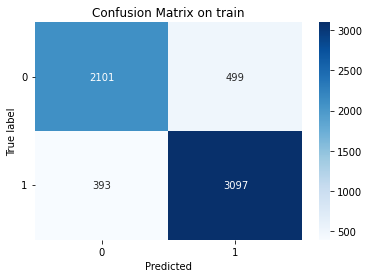

In [34]:
# Plot confusion matrix
cm = confusion_matrix(y_train_, pred_tweets_train)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
plt.title("Confusion Matrix on train")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

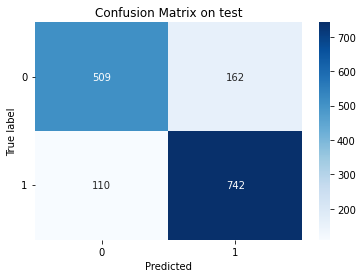

In [35]:
# Plot confusion matrix
cm = confusion_matrix(y_test, pred_tweets_test)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
plt.title("Confusion Matrix on test")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show() 

## Inference

In [43]:
pd.set_option('display.max_colwidth', None)

In [45]:
predictor.predict("The possible new jerseys for the Avalanche next year. ????")

'not_disaster'

In [46]:
X_test.loc[542,:]

text              The possible new jerseys for the Avalanche next year. ???? http://t.co/nruzhR5XQu
classification                                                                         not_disaster
Name: 542, dtype: object

In [48]:
predictor.predict('Car engulfed in flames backs up traffic at Parleys Summit ?')

'disaster'

In [49]:
X_test.loc[3264,:]

text              Car engulfed in flames backs up traffic at ParleyÛªs Summit http://t.co/RmucfjCaZr
classification                                                                               disaster
Name: 3264, dtype: object

In [53]:
predictor.predict("Small casualty on the way to Colorado")

'disaster'

In [54]:
X_test.loc[1459,:]

text              Small casualty on the way to Colorado http://t.co/hDVmhSQXHm
classification                                                        disaster
Name: 1459, dtype: object

In [56]:
predictor.predict("Bicycle-SUV accident in Mesick: Police say that the bicyclist entered onto West M-115 and collided with a boat...")

'disaster'

In [58]:
X_test.loc[1730,:]

text              Bicycle-SUV accident in Mesick: Police say that the bicyclist entered onto West M-115 and collided with a boat... http://t.co/A9gtOPyZK8
classification                                                                                                                                    disaster
Name: 1730, dtype: object

In [60]:
predictor.predict('Oil prices falling but drivers could reap benefits')

'not_disaster'

In [61]:
X_test.loc[1903,:]

text              Oil prices falling but drivers could reap benefits http://t.co/QlTwhoJqYA
classification                                                                 not_disaster
Name: 1903, dtype: object